In [1]:
import sys, os
import random
import numpy as np
from glob import glob
import pandas as pd
import kaldiio
import torch
import pickle
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from tdnn import TDNN
from pytorch_model_summary import summary
import matplotlib.pyplot as plt
from pickle import Pickler, Unpickler


random.seed(1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

in_set = ['ENG', 'GER', 'ICE', 'FRE', 'SPA', 'ARA', 'RUS', 'BEN', 'KAS', 'GRE', 'CAT', 'KOR', 'TUR', 'TAM', 'TEL', 'CHI', 'TIB', 'JAV', 'EWE', 'HAU', 'LIN', 'YOR', 'HUN', 'HAW', 'MAO', 'ITA', 'URD', 'SWE', 'PUS', 'GEO', 'HIN', 'THA']
out_of_set = ['DUT', 'HEB', 'UKR', 'BUL', 'PER', 'ALB', 'UIG', 'MAL', 'BUR', 'IBA', 'ASA', 'AKU', 'ARM', 'HRV', 'FIN', 'JPN', 'NOR', 'NEP', 'RUM']

langs = in_set + out_of_set

num_in_set = 32

in_set = langs[:num_in_set]
out_of_set = langs[num_in_set:]

root_dir = "db/cu-multilang-dataset/"

isolated_speakers = {
    "ENG": [27, 28, 29, 30],
    "SPA": [30]
}


assert(len(in_set) + len(out_of_set) == 51)
assert(len(set(in_set).intersection(set(out_of_set))) == 0)
for lang in os.listdir(root_dir):
    assert(lang in in_set or lang in out_of_set)


clip_size = 3
hours_per_lang = 4
num_epochs = 15

cuda:0


In [2]:
class LanguageDataset(Dataset):
    def __init__(self, chunks):
        self.chunks=chunks
        
    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, index):
        el = self.chunks[index]
        sample = el[0].squeeze()
        label = el[1][0]
        
        return sample, label

In [3]:
class Net(nn.Module):
    def __init__(self, in_size, num_classes):
        super().__init__()
        
        self.layer1 = TDNN(input_dim=in_size, output_dim=256, context_size=3)
        self.layer2 = TDNN(input_dim=256, output_dim=256, context_size=3, dilation=1)
        self.layer3 = TDNN(input_dim=256, output_dim=256, context_size=3, dilation=1)
        self.layer4 = TDNN(input_dim=256, output_dim=256, context_size=1)
        self.layer5 = TDNN(input_dim=256, output_dim=256, context_size=1)
        self.final_layer = TDNN(input_dim=256, output_dim=num_classes, context_size=1)
        
    def forward(self, x):
        forward_pass = nn.Sequential(
            self.layer1,
            nn.ReLU(),
            self.layer2,
            nn.ReLU(),
            self.layer3,
            nn.ReLU(),
            self.layer4,
            nn.ReLU(),
            self.layer5,
            nn.ReLU(),
            self.final_layer)
        
        return forward_pass(x)
    
print(summary(Net(16, len(in_set)), torch.zeros((256, 300, 16)), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
            TDNN-1     [256, 298, 256]          13,056          13,056
            TDNN-2     [256, 296, 256]         197,376         197,376
            TDNN-3     [256, 294, 256]         197,376         197,376
            TDNN-4     [256, 294, 256]          66,304          66,304
            TDNN-5     [256, 294, 256]          66,304          66,304
            TDNN-6      [256, 294, 32]           8,288           8,288
Total params: 548,704
Trainable params: 548,704
Non-trainable params: 0
-----------------------------------------------------------------------


In [4]:
def create_train_test_data(switch_point=0.8, batch_size=512):
    print("\n-----Getting Train/Test Data-----\n")

    train, test, oos_test = [], [], []

    max_sample_length = clip_size * 100
    num_chunks_per_file = (hours_per_lang * 3600) / (clip_size * 30)
    switch_point = 0.8

    for i,lang in enumerate(in_set + out_of_set, 0):
        print(lang, "(In-set)" if lang in in_set else "(Out-of-set)")

        chunks = []
        for f_idx in range(1, 31):
            if lang in isolated_speakers and f_idx in isolated_speakers[lang]:
                continue

            filepath = root_dir + lang + '/data/raw_mfcc_pitch_' + lang + '.' + str(f_idx) + '.ark'
            file_chunks = []

            for key, numpy_array in kaldiio.load_ark(filepath):
                curr_len = len(numpy_array)

                if curr_len >= max_sample_length:
                    file_chunks +=  np.split(numpy_array, np.arange(max_sample_length, curr_len, max_sample_length))[:-1]
                else:
                    padded_chunk = np.pad(numpy_array, ((max_sample_length - curr_len, 0), (0, 0)), "constant")
                    file_chunks += [padded_chunk]

                if len(file_chunks) >= num_chunks_per_file:
                    chunks += file_chunks
                    break

        random.shuffle(chunks)
        chunks= np.array(chunks)

        for j, chunk in enumerate(chunks):
            inputs = torch.from_numpy(chunk)
            inputs.to(device)
            labels = torch.from_numpy(np.array([i if lang in in_set else -1]))
            labels.to(device)

            if j + 1 <= switch_point * len(chunks):
                if lang in in_set:
                    train.append((inputs,labels))
            else:
                if lang in in_set:
                    test.append((inputs, labels))
                else:
                    oos_test.append((inputs, labels))

    print()
    print(len(train))
    print(len(test))
    print(len(oos_test))
    print("\n-----Finished Data Splitting-----\n")
    print("Creating Train and Test loaders...")
    
    batch_size = 512

    train_set = LanguageDataset(train)
    val_set = LanguageDataset(test)
    train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_set, shuffle=True, batch_size=batch_size)
    
    
    return train_loader, val_loader, test + oos_test





In [5]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train_model(model, train_loader, optimizer, criterion, device=None):
    train_loss = 0.0
    train_acc = 0.0

    model.train()

    for x, y in train_loader:
      # Send to GPU if available
      if device is not None:
        x = x.to(device)
        y = y.to(device)

      optimizer.zero_grad()

      y_pred = model(x)
      y_pred = torch.mean(y_pred, 1)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)

      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_acc += acc.item()

    return train_loss / len(train_loader), train_acc / len(train_loader)


def evaluate_model(model, val_loader, criterion, device=None):
    val_loss = 0.0
    val_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
          # Send to GPU if available
          if device is not None:
            x = x.to(device)
            y = y.to(device)

          y_pred = model(x)
          y_pred = torch.mean(y_pred, 1)
          loss = criterion(y_pred, y)
          acc = calculate_accuracy(y_pred, y)

          val_loss += loss.item()
          val_acc += acc.item()

    return val_loss / len(val_loader), val_acc / len(val_loader)


In [6]:
def train_network(net, train_loader, val_loader):
    # Initialize the TDNN, loss, and optimizer
    net.to(device)
    criterion = nn.CrossEntropyLoss() # a common loss function for multi-class classification problems
    optimizer = optim.AdamW(net.parameters(), lr=0.001) # a common optimizer for multi-class classification problems

    SAVE_PATH = "saved_models/tdnn-256-" + str(hours_per_lang) + "h-" + str(clip_size) + "s-" + str(num_epochs) + "epochs"

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_loss = float('inf')
    best_epoch = 0

    print('Started Training')

    for epoch in range(num_epochs):  # number of epochs
        train_loss, train_accuracy = train_model(net, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = evaluate_model(net, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_loss:
          best_loss = val_loss
          best_epoch = epoch

          with open(SAVE_PATH + ".pickle", "wb") as outfile:
            pickle.dump(net, outfile, protocol=4)


        print("Epoch: " + str(epoch) + ", Train Loss: " + str(train_loss) + ", Train Accuracy: " + str(train_accuracy) + \
            ", Val Loss: " + str(val_loss) + ", Val Accuracy: " + str(val_accuracy))


    torch.save(net.state_dict(), SAVE_PATH + ".pth") # Save the model

    print("Best Val Loss: " + str(best_loss) + " at Epoch: " + str(best_epoch))

    print('Finished Training')

    return train_losses, train_accuracies, val_losses, val_accuracies
    

In [7]:
def save_plots(train_losses, train_accuracies, val_losses, val_accuracies):
    model_name = "TDNN trained on " + str(hours_per_lang) + " hours per language in " + str(clip_size) + "s clips for " + str(num_epochs) + " epochs"
    
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Valid")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(model_name)

    res_path = os.path.join("./", "results", str(hours_per_lang) + "h", str(clip_size) + "s", str(num_epochs) + "epochs")
    os.makedirs(res_path, exist_ok=True)
    plt.savefig(os.path.join(res_path, "loss_plot"))
    
    plt.clf()

    plt.plot(train_accuracies, label="Train")
    plt.plot(val_accuracies, label="Valid")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (Super)")
    plt.legend()
    plt.title(model_name)

    plt.savefig(os.path.join(res_path, "accuracy_plot"))
    
    plt.close()


In [8]:
def test_with_oos(model, test_set):
    # infile = open("saved_models/tdnn-256-2s-4h.pickle", "rb")
    # new_net = Unpickler(infile).load()
    # infile.close()

    res = {}

    for thresh in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        correct = 0
        for x, y in test_set:
          # Send to GPU if available
          if device is not None:
            x = x.to(device)
            y = y.to(device)

          x = x.unsqueeze(0)
          y_pred = model(x)
          y_pred = torch.mean(y_pred, 1)
          y_pred = F.softmax(y_pred, dim=1)

          conf = y_pred.amax(1, keepdim=True).item()
          if conf > thresh:
              top_pred = y_pred.argmax(1, keepdim=True)
          else:
              top_pred = -1

          if top_pred == y:
            correct += 1

        acc = correct / len(test_set)
        print(thresh, acc)

        res[str(thresh)] = str(acc)

    return res
    



-----Getting Train/Test Data-----

ENG (In-set)
GER (In-set)
ICE (In-set)
FRE (In-set)
SPA (In-set)
ARA (In-set)
RUS (In-set)
BEN (In-set)
KAS (In-set)
GRE (In-set)
CAT (In-set)
KOR (In-set)
TUR (In-set)
TAM (In-set)
TEL (In-set)
CHI (In-set)
TIB (In-set)
JAV (In-set)
EWE (In-set)
HAU (In-set)
LIN (In-set)
YOR (In-set)
HUN (In-set)
HAW (In-set)
MAO (In-set)
ITA (In-set)
URD (In-set)
SWE (In-set)
PUS (In-set)
GEO (In-set)
HIN (In-set)
THA (In-set)
DUT (Out-of-set)
HEB (Out-of-set)
UKR (Out-of-set)
BUL (Out-of-set)
PER (Out-of-set)
ALB (Out-of-set)
UIG (Out-of-set)
MAL (Out-of-set)
BUR (Out-of-set)
IBA (Out-of-set)
ASA (Out-of-set)
AKU (Out-of-set)
ARM (Out-of-set)
HRV (Out-of-set)
FIN (Out-of-set)
JPN (Out-of-set)
NOR (Out-of-set)
NEP (Out-of-set)
RUM (Out-of-set)

112152
28053
11283

-----Finished Data Splitting-----

Creating Train and Test loaders...
Started Training
Epoch: 0, Train Loss: 1.6742218646136198, Train Accuracy: 0.6858605588024312, Val Loss: 1.2927613713524557, Val Accur

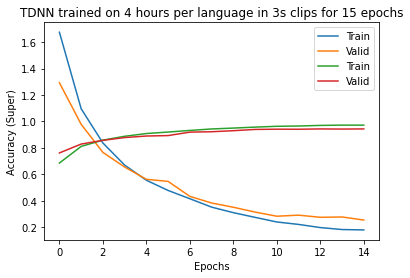

In [9]:
train_loader, val_loader, test_set = create_train_test_data(switch_point=0.8, batch_size=512)

net = Net(16, len(in_set)).to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train_network(net, train_loader, val_loader)
save_plots(train_losses, train_accuracies, val_losses, val_accuracies)

results_with_oos = test_with_oos(net, test_set)
    